# 3.1 Motion through pose composition

A fundamental aspect of the development of mobile robots is the motion itself. This is not a trivial matter, as many sources of motion error appear: 
- wheel slippage, 
- inaccurate calibration,
- limited resolution during integration (time increments, measurement resolution), or
- unequal floor, among others.

These factors introduce uncertainty in the robot motion. Additionally, other constraints to the movement difficult its implementation. This particular chapter explores the concept of *robot's pose* and how we deal with it in a probabilistic context.

The pose itself can take multiple forms depending on the problem context:

- **2D location**: In a planar context we only need to a 2d vector $[x, y]^T$ to locate a robot against a point of reference, the origin $(0, 0).$
- **2D pose**: In most cases involving mobile robots, the location alone is insufficient. We need an additional parameter known as orientation or *bearing*. Therefore, a robot's pose is usually expressed as $[x, y, \theta]^T$ (see Fig. 1). *In the rest of the book, we mostly refer to this one.*
- **3D pose**: Although we will only mention it in passing, for robotics applications in the 3D space, *i.e.* UAV or drones, not only a third axis $z$ is added, but to handle the orientation in a 3D environment we need 3 components, *i.e.* roll, pitch and yaw. This course is centered around planar mobile robots so we will not use this one, nevertheless most methods could be adapted to 3D environments.

<figure style="text-align:center">
  <img src="images/pose-composition.png" alt="" width="400px">
  <figcaption>Fig. 1: Example of an initial 2D robot pose ($p_1$) and its resultant pose ($p_2$) after completing a motion ($\Sigma p$).</figcaption>
</figure>

In this chapter we will explore how to use the **composition of poses** to express poses in a certain reference system, while the next two chapters describe two probabilistic methods for dealing with the uncertainty inherent to robot motion, namely the **velocity-based** motion model and the **odometry-based** one. 

In [1]:
%matplotlib notebook

# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import sys
sys.path.append("..")
from utils.DrawRobot import DrawRobot
from utils.tcomp import tcomp

## <span style="color:green">OPTIONAL</span>

<span style="color:green">In the Robot motion lecture, we started talking about *Differential drive* motion systems. Include as many cells as needed to introduce the background that you find interesting about it and some code illustrating some related aspect, for example, a code computing and plotting the *Instantaneus Center of Rotation (ICR)* according to a number of given parameters.</span>

<span style="color:green">***END OF OPTIONAL PART***</span>

## 3.1 Pose composition <a id="pose_composition"></a>

The composition of posses is a tool that permits us to express the *final* pose of a robot in an arbitrary coordinate system. Given an initial pose $p_1$ and a pose differential $\Delta p$, *i.e.* how much the robot has moved during an interval of time, we compute the final pose $p$ using the **composition of poses** function:

$$
    p_1 = 
        \begin{bmatrix}
            x_1 \\ y_1 \\ \theta_1
        \end{bmatrix}, \, \, \,
    \Delta p = 
        \begin{bmatrix}
            \Delta x \\ \Delta y \\ \Delta \theta
        \end{bmatrix}
$$

$$
    \begin{equation}
    p = \begin{bmatrix}
            x \\ y \\ \theta
        \end{bmatrix}
        = p_1 \oplus \Delta p
        = \begin{bmatrix}
            x_1 + \Delta x \cos \theta_1 - \Delta y \sin \theta_1 \\ 
            y_1 + \Delta x \sin \theta_1 + \Delta y \cos \theta_1 \\
            \theta_1 + \Delta \theta
          \end{bmatrix}
    \end{equation}
$$


The differential $\Delta p$, although we are using it as control in this exercise, normally is calculated given the robot's locomotion or sensed by the wheel encoders.

## <span style="color:green">OPTIONAL</span>

<span style="color:green">Implement your own methods to compute the composition of two poses, as well as the inverse composition. Include some examples of their utilization, also incorporating plots.</span>

<span style="color:green">***END OF OPTIONAL PART***</span>

### **<span style="color:green"><b><i>ASSIGNMENT 1: Moving the robot by composing pose increments</i></b></span>**

Take a look at the `Robot()` class provided and its methods: the constructor, `step()` and `draw()`. Then, modify the main function in the next cell for the robot to describe a $8m \times 8m$ square path as seen in the figure below. You must take into account that:

- The robot starts in the bottom-left corner $(0, 0)$ heading north and 
- moves at increments of $2 m$ each step. 
- Each 4 steps, it will turn right.

**Example**


<figure style="text-align:center">
  <img src="images/fig3-1-1.png" alt="">
  <figcaption>Fig. 2: Route of our robot.</figcaption>
</figure>

In [2]:
class Robot():
    '''Mobile robot implementation
    
        Attr:
            pose: Expected position of the robot
    '''
    def __init__(self, mean):
        self.pose = mean

    def step(self, u):
        self.pose = tcomp(self.pose, u)
    
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose)

In [3]:
def main(robot):
    
    # PARAMETERS INITIALIZATION
    num_steps = 15 # Number of robot motions
    turning = 4  # Number of steps for turning
    u = np.vstack([2., 0., 0.]) # Motion command (pose increment)
    angle_inc = -np.pi/2 # Angle increment
    
    # VISUALIZATION
    fig, ax = plt.subplots()
    plt.ion()
    plt.draw()
    plt.xlim((-2, 10))
    plt.ylim((-2, 10))
    
    plt.grid()
    robot.draw(fig, ax)
    
    # MAIN LOOP
    for step in range(1,num_steps+1):
        
        # Check if the robot has to move in straight line or also has to turn
        # and accordingly set the third component (rotation) of the motion command 
        
        turning = turning -1
           
        if turning == 0:
            u[2] = u[2]+angle_inc
            turning = 4
        else:
            u[2]=0
            
        
        # Execute the motion command        
        robot.step(u)
        
        # VISUALIZATION
        robot.draw(fig, ax)
        fig.canvas.draw()
        plt.pause(0.2)   
    


Execute the following code cell to **try your code**. The resulting figure must be the same as Fig. 2.

<IPython.core.display.Javascript object>


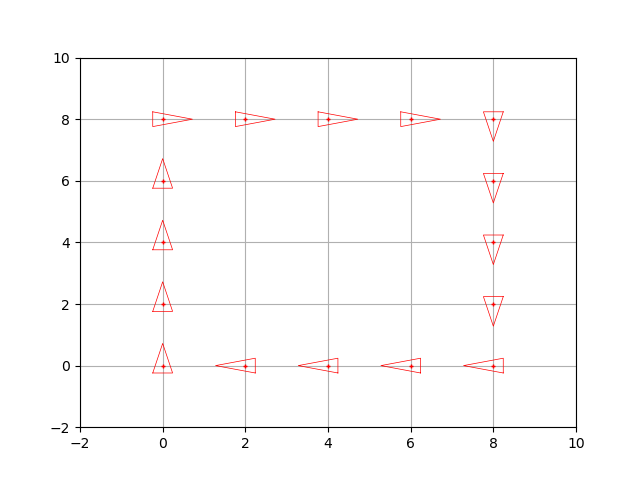

In [4]:
# RUN 
initial_pose = np.vstack([0., 0., np.pi/2])
robot = Robot(initial_pose)
main(robot)

## 3.2 Considering noise

In the previous case, the robot motion was error-free. This is overly optimistic as in a real use case the conditions of the environment are a huge source of uncertainty.

To take into consideration such uncertainty, we will model the movement of the robot as a (multidimensional) gaussian distribution $\Delta p \sim N(\mu_{\Delta p},\Sigma_{\Delta p})$ where:

- The mean $\mu_{\Delta p}$ is still the pose differential in the previous exercise, that is $\Delta p_{\text{given}}$.
- The covariance $\Sigma_{\Delta p}$ is a $3 \times 3$ matrix, which defines the amount of error at each step (time interval). 

### **<span style="color:green"><b><i>ASSIGNMENT 2: Adding noise to the pose motion</i></b></span>**

Now, we are going to add a Gaussian noise to the motion, assuming that the incremental motion now follows the probability distribution:

$$
    \Delta p = N(\Delta p_{given}, \Sigma_{\Delta p})
    \textit{ with } 
    \Sigma_{\Delta p}  =
        \begin{bmatrix}
            0.04 & 0 & 0 \\
            0 & 0.04 & 0 \\
            0 & 0 & 0.01
        \end{bmatrix}
    (\text{ units in }m^2 \text{ and } rad^2)
$$

For doing that, complete the `NosyRobot()` class below, which is a child class of the previous `Robot()` one. Concretely, you have to:

- Complete this new class by adding some amount of noise to the movement (take a look at the `step()` method. *Hints: [`np.vstack()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html), [`stats.multivariate_normal.rvs()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html)*. 
Remark that we have now two variables related to the robot pose:
  - `self.pose`, which represents the expected, *ideal* pose, and
  - `self.true_pose`, that stands for the actual pose after carrying out a noisy motion command.
- Along with the expected pose drawn in red (`self.pose`), in the `draw()` method plot the real pose of the robot (`self.true_pose`) in blue, which as commented is affected by noise. 

Run the cell several times to see that the motion (and the path) is different each time. Try also with different values of the covariance matrix.

**Example**

<figure style="text-align:center">
  <img src="images/fig3-1-2.png" alt="">
  <figcaption>Fig. 3: Movement of our robot using pose compositions. <br/>
      Containing the expected poses (in red) and the true pose <br/> affected by noise (in blue)</figcaption>
</figure>

In [5]:
class NoisyRobot(Robot):
    """Mobile robot implementation. It's motion has a set ammount of noise.
    
        Attr:
            pose: Inherited from Robot
            true_pose: Real robot pose, which has been affected by some ammount of noise.
            covariance: Amount of error of each step.
    """
    def __init__(self, mean, covariance):
        super().__init__(mean)
        self.true_pose = mean
        self.covariance = covariance
        
    def step(self, step_increment):
        """Computes a single step of our noisy robot.
        
            super().step(...) updates the expected pose (without noise)
            Generate a noisy increment based on step_increment and self.covariance.
            Then this noisy increment is applied to self.true_pose
        """
        super().step(step_increment)
        
        true_step = stats.multivariate_normal.rvs(step_increment.flatten(), self.covariance)
        self.true_pose = tcomp(self.true_pose, np.vstack(true_step))
        
    def draw(self, fig, ax):
        super().draw(fig, ax)
        DrawRobot(fig, ax, self.true_pose, self.covariance, color='blue')

<IPython.core.display.Javascript object>


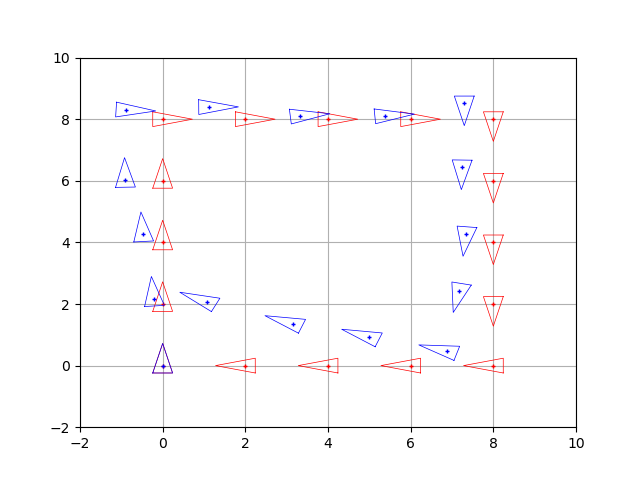

In [11]:
# RUN 
initial_pose = np.vstack([0., 0., np.pi/2])
cov = np.diag([0.04, 0.04, 0.01])  

robot = NoisyRobot(initial_pose, cov)
main(robot)

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now that you are an expert in retrieving the pose of a robot after carrying out a motion command defined as a pose increment, **answer the following questions**:

- Why are the expected (blue) and true (red) poses different?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Because the red pose is the expected and without errors pose and the blue one have some noise added.</i></p>

- In which scenario could they be the same?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>In the one which the noise of the robot is equals to zero. This idilic situation could happen using errorless sensors for example.</i></p>
    
- How affect the values in the covariance matrix $\Sigma_{\Delta p}$ the robot motion?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>When the diagonal values of the covariance matrix are higher, more dispersed could be our robot pose.</i></p>